In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
from matplotlib.pyplot import text

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [9]:
import binpacking
import random
import re

In [10]:
!ls /home/aati2/huawei

cpu_limit_minute	   instances_minute	    public_dataset
cpu_limit_minute.zip	   instances_minute.zip     public_dataset.zip
cpu_usage_minute	   memory_limit_minute	    requests_minute
cpu_usage_minute.zip	   memory_limit_minute.zip  requests_minute.zip
function_delay_minute	   memory_usage_minute	    requests_second
function_delay_minute.zip  memory_usage_minute.zip  requests_second.zip


In [11]:
dataset_all = !ls /home/aati2/huawei/cpu_usage_minute
dataset_all

['day_000.csv',
 'day_001.csv',
 'day_002.csv',
 'day_003.csv',
 'day_004.csv',
 'day_005.csv',
 'day_006.csv',
 'day_007.csv',
 'day_008.csv',
 'day_009.csv',
 'day_010.csv',
 'day_011.csv',
 'day_012.csv',
 'day_013.csv',
 'day_014.csv',
 'day_015.csv',
 'day_016.csv',
 'day_017.csv',
 'day_018.csv',
 'day_028.csv',
 'day_029.csv',
 'day_030.csv',
 'day_031.csv',
 'day_032.csv',
 'day_033.csv',
 'day_034.csv',
 'day_035.csv',
 'day_036.csv',
 'day_037.csv',
 'day_038.csv',
 'day_039.csv',
 'day_040.csv',
 'day_041.csv',
 'day_042.csv',
 'day_043.csv',
 'day_044.csv',
 'day_045.csv',
 'day_046.csv',
 'day_047.csv',
 'day_048.csv',
 'day_049.csv',
 'day_050.csv',
 'day_051.csv',
 'day_052.csv',
 'day_053.csv',
 'day_054.csv',
 'day_055.csv',
 'day_056.csv',
 'day_057.csv',
 'day_058.csv',
 'day_059.csv',
 'day_060.csv',
 'day_117.csv',
 'day_118.csv',
 'day_119.csv',
 'day_120.csv',
 'day_121.csv',
 'day_122.csv',
 'day_123.csv',
 'day_124.csv',
 'day_125.csv',
 'day_126.csv',
 'day_12

In [12]:
server_cpu_capacity = int(96 / 2)
server_mem_capacity = int(192000 / 2)


In [13]:
usage_file = "day_117.csv"
funcs = [str(x) for x in range(200)]

days = []
dfreqs_all = []
dfdelay_all = []

for day_file in dataset_all:

    dfinstances = pd.read_csv(f'/home/aati2/huawei/instances_minute/{day_file}')  
    dfreqs = pd.read_csv(f'/home/aati2/huawei/requests_minute/{day_file}') 
    dfdelay = pd.read_csv(f'/home/aati2/huawei/function_delay_minute/{day_file}')  

    dfcpu_usage = pd.read_csv(f'/home/aati2/huawei/cpu_usage_minute/{day_file}')  
    dfcpu_limit = pd.read_csv(f'/home/aati2/huawei/cpu_limit_minute/{day_file}') 

    dfmem_usage = pd.read_csv(f'/home/aati2/huawei/memory_usage_minute/{day_file}')       
    dfmem_limit = pd.read_csv(f'/home/aati2/huawei/memory_limit_minute/{day_file}')    
    
    days.append((dfinstances, dfcpu_usage, dfcpu_limit, dfmem_usage, dfmem_limit))
    
    dfreqs_all.append(dfreqs)
    dfdelay_all.append(dfdelay)


# Load variance

8207999.0 6.749399724366586


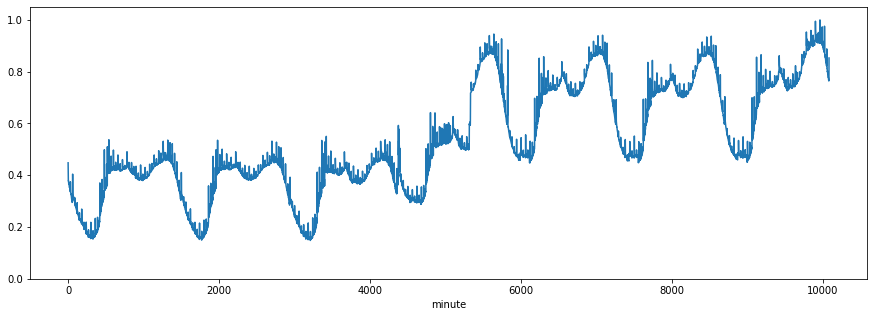

10930618.0 10.582444977785867


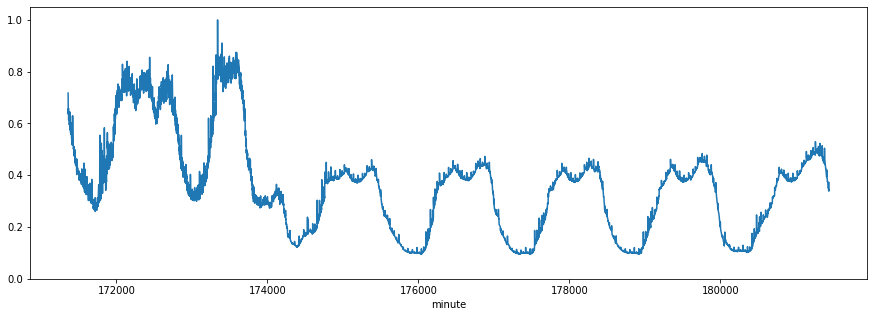

In [12]:
df = pd.concat(dfreqs_all)

df = df.reset_index()

df['minute'] = (df['day'] * 1440) +  df['index']


peak_to_trough_values = []

for index, offset in enumerate(range(0, 235, 7)):
    
    if index == 0 or index == 17:
    
        a = offset*1440
        b = a + (1440*7)

        dfweek = df.set_index('minute').loc[a:b]

        dfagg_load = dfweek[funcs].sum(axis=1)

        peak_per_week = dfagg_load.max()

        peak_to_trough = (1/(dfagg_load/dfagg_load.max()).min())
        print(dfagg_load.max(), peak_to_trough)
        (dfagg_load/dfagg_load.max()).plot(figsize=(15,5))
        plt.ylim(0,1.05)
        
#         plt.savefig(f"/local/scratch/phd-figures/workload-variance-{index}.pdf", format="pdf", bbox_inches="tight")
        
        plt.show()

        peak_to_trough_values.append(peak_to_trough)
    



# Peak-based resource allocation

In [145]:
capacity_planning_interval = 24*60*50
capacity_planning_interval = 203040


cluster_usage.shape,capacity_planning_interval

((203040, 202), 203040)

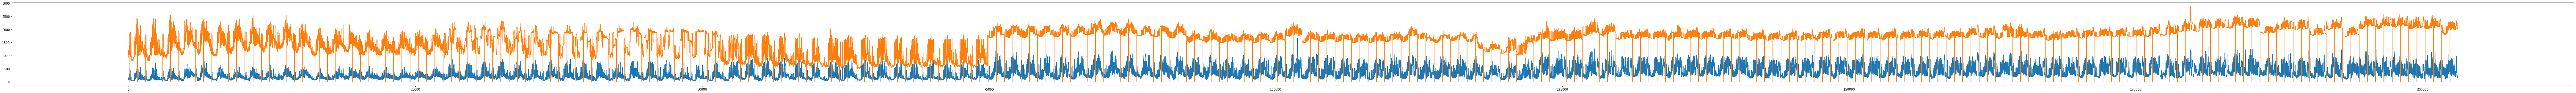

In [147]:

#     ideal_capacity = get_ideal_capacity(days[52],1)

dfinstances_multipledays = pd.concat([dfinstances for dfinstances, _, _, _, _ in days[:]])
dfcpu_usage_multipledays = pd.concat([dfcpu_usage for _, dfcpu_usage, _, _, _ in days[:]])
dfcpu_limit_multipledays = pd.concat([dfcpu_limit for _, _, dfcpu_limit, _, _ in days[:]])

dfmem_usage_multipledays = pd.concat([dfmem_usage for _, _, _, dfmem_usage, _ in days[:]])
dfmem_limit_multipledays = pd.concat([dfmem_limit for _, _, _, _, dfmem_limit in days[:]])

cluster_usage = dfinstances_multipledays * dfcpu_usage_multipledays * dfcpu_limit_multipledays
cluster_user_allocation = dfinstances_multipledays * dfcpu_limit_multipledays
instance_usage = dfcpu_usage_multipledays * dfcpu_limit_multipledays
instance_allocation = dfcpu_limit_multipledays

cluster_usage_mem = dfinstances_multipledays * dfmem_usage_multipledays * dfmem_limit_multipledays
cluster_user_allocation_mem = dfinstances_multipledays * dfmem_limit_multipledays

cluster_usage[funcs].sum(axis=1).reset_index()[0].plot(figsize=(30*5,5))
cluster_user_allocation[funcs].sum(axis=1).reset_index()[0].plot(figsize=(30*5,5))

replica_usage = dfcpu_usage_multipledays * dfcpu_limit_multipledays
replica_usage_mem = dfmem_usage_multipledays * dfmem_limit_multipledays



In [153]:


peak_limits_cpu_per_window = []
peak_limits_mem_per_window = []

tau_windows = [144,1440]

for tau_window in tau_windows:
    
    print(tau_window)
    
    dfs = []
    dfs_mem = []
    for tau_offset in range(0,capacity_planning_interval,tau_window):
        print(tau_offset)
        tau = range(tau_offset,tau_offset+tau_window)
        max_usage = replica_usage[funcs].fillna(0).iloc[tau].max().values
        max_usage_mem = replica_usage_mem[funcs].fillna(0).iloc[tau].max().values

        df = pd.DataFrame(columns=funcs)
        df['minute'] = tau
        for func in funcs:
            df[func] = df[func].apply(lambda row: max_usage[int(func)])
        dfs.append(df)
        
        df_mem = pd.DataFrame(columns=funcs)
        df_mem['minute'] = tau
        for func in funcs:
            df_mem[func] = df_mem[func].apply(lambda row: max_usage_mem[int(func)])
        dfs_mem.append(df_mem)        
        
    limits = pd.concat(dfs)
    limits_mem = pd.concat(dfs_mem)
    
    peak_limits_cpu_per_window.append(limits)
    peak_limits_mem_per_window.append(limits_mem)

144
0
144
288
432
576
720
864
1008
1152
1296
1440
1584
1728
1872
2016
2160
2304
2448
2592
2736
2880
3024
3168
3312
3456
3600
3744
3888
4032
4176
4320
4464
4608
4752
4896
5040
5184
5328
5472
5616
5760
5904
6048
6192
6336
6480
6624
6768
6912
7056
7200
7344
7488
7632
7776
7920
8064
8208
8352
8496
8640
8784
8928
9072
9216
9360
9504
9648
9792
9936
10080
10224
10368
10512
10656
10800
10944
11088
11232
11376
11520
11664
11808
11952
12096
12240
12384
12528
12672
12816
12960
13104
13248
13392
13536
13680
13824
13968
14112
14256
14400
14544
14688
14832
14976
15120
15264
15408
15552
15696
15840
15984
16128
16272
16416
16560
16704
16848
16992
17136
17280
17424
17568
17712
17856
18000
18144
18288
18432
18576
18720
18864
19008
19152
19296
19440
19584
19728
19872
20016
20160
20304
20448
20592
20736
20880
21024
21168
21312
21456
21600
21744
21888
22032
22176
22320
22464
22608
22752
22896
23040
23184
23328
23472
23616
23760
23904
24048
24192
24336
24480
24624
24768
24912
25056
25200
25344
25488
25632
2

184464
184608
184752
184896
185040
185184
185328
185472
185616
185760
185904
186048
186192
186336
186480
186624
186768
186912
187056
187200
187344
187488
187632
187776
187920
188064
188208
188352
188496
188640
188784
188928
189072
189216
189360
189504
189648
189792
189936
190080
190224
190368
190512
190656
190800
190944
191088
191232
191376
191520
191664
191808
191952
192096
192240
192384
192528
192672
192816
192960
193104
193248
193392
193536
193680
193824
193968
194112
194256
194400
194544
194688
194832
194976
195120
195264
195408
195552
195696
195840
195984
196128
196272
196416
196560
196704
196848
196992
197136
197280
197424
197568
197712
197856
198000
198144
198288
198432
198576
198720
198864
199008
199152
199296
199440
199584
199728
199872
200016
200160
200304
200448
200592
200736
200880
201024
201168
201312
201456
201600
201744
201888
202032
202176
202320
202464
202608
202752
202896
1440
0
1440
2880
4320
5760
7200
8640
10080
11520
12960
14400
15840
17280
18720
20160
21600
23040


0.16284807906804638

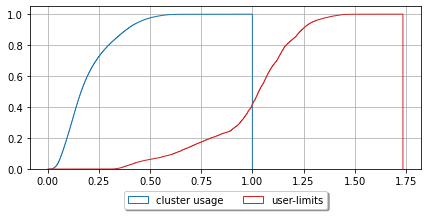

In [150]:

cluster_utilisation = cluster_usage.iloc[0:capacity_planning_interval][funcs].sum(axis=1).reset_index()[0]
(cluster_utilisation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='cluster usage',color="tab:blue",figsize=(7,3)) 

cluster_overprovisioning = cluster_user_allocation.iloc[0:capacity_planning_interval][funcs].sum(axis=1).reset_index()[0]
(cluster_overprovisioning/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='user-limits',color='tab:red') 

# linestyles= ["--","solid"]
# for i, peak_limits in enumerate(peak_limits_cpu_per_window[:]):    
#     cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[0:capacity_planning_interval]).sum(axis=1)
#     (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'peak-limits ({allocations_ranges[i]}m-window)',linestyle=linestyles[i],color='tab:purple')

plt.legend(loc='upper left')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.savefig("/local/scratch/phd-figures/peak-vs-user-limits-cpu.pdf", format="pdf", bbox_inches="tight")

(cluster_utilisation/cluster_utilisation.max()).median()

0.4834933203617473

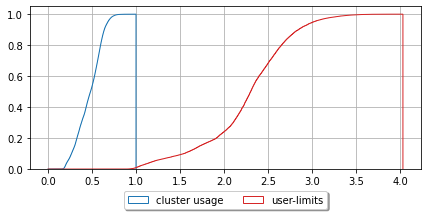

In [151]:

cluster_utilisation = cluster_usage_mem.iloc[0:capacity_planning_interval][funcs].sum(axis=1).reset_index()[0]
(cluster_utilisation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='cluster usage',color="tab:blue",figsize=(7,3)) 

cluster_overprovisioning = cluster_user_allocation_mem.iloc[0:capacity_planning_interval][funcs].sum(axis=1).reset_index()[0]
(cluster_overprovisioning/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='user-limits',color='tab:red') 

# linestyles= ["--","solid"]
# for i, peak_limits in enumerate(peak_limits_mem_per_window[:]):    
#     cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[0:capacity_planning_interval]).sum(axis=1)
#     (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'peak-limits ({allocations_ranges[i]}m-window)',linestyle=linestyles[i],color='tab:purple')

plt.legend(loc='upper left')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.savefig("/local/scratch/phd-figures/peak-vs-user-limits-mem.pdf", format="pdf", bbox_inches="tight")

(cluster_utilisation/cluster_utilisation.max()).median()

# Usage-based resource overcommitment

In [152]:


oc_limits_cpu_per_window = []
oc_limits_mem_per_window = []

tau_windows = [1440]

for tau_window in tau_windows:
    
    print(tau_window)
    
    dfs = []
    dfs_mem = []
    for tau_offset in range(0,capacity_planning_interval,tau_window):
        print(tau_offset)
        tau = range(tau_offset,tau_offset+tau_window)
        max_usage = replica_usage[funcs].fillna(0).iloc[tau].quantile(0.99).values
        max_usage_mem = replica_usage_mem[funcs].fillna(0).iloc[tau].quantile(0.99).values

        df = pd.DataFrame(columns=funcs)
        df['minute'] = tau
        for func in funcs:
            df[func] = df[func].apply(lambda row: max_usage[int(func)])
        dfs.append(df)
        
        df_mem = pd.DataFrame(columns=funcs)
        df_mem['minute'] = tau
        for func in funcs:
            df_mem[func] = df_mem[func].apply(lambda row: max_usage_mem[int(func)])
        dfs_mem.append(df_mem)        
        
    limits = pd.concat(dfs)
    limits_mem = pd.concat(dfs_mem)
    
    oc_limits_cpu_per_window.append(limits)
    oc_limits_mem_per_window.append(limits_mem)
    
        

1440
0
1440
2880
4320
5760
7200
8640
10080
11520
12960
14400
15840
17280
18720
20160
21600
23040
24480
25920
27360
28800
30240
31680
33120
34560
36000
37440
38880
40320
41760
43200
44640
46080
47520
48960
50400
51840
53280
54720
56160
57600
59040
60480
61920
63360
64800
66240
67680
69120
70560
72000
73440
74880
76320
77760
79200
80640
82080
83520
84960
86400
87840
89280
90720
92160
93600
95040
96480
97920
99360
100800
102240
103680
105120
106560
108000
109440
110880
112320
113760
115200
116640
118080
119520
120960
122400
123840
125280
126720
128160
129600
131040
132480
133920
135360
136800
138240
139680
141120
142560
144000
145440
146880
148320
149760
151200
152640
154080
155520
156960
158400
159840
161280
162720
164160
165600
167040
168480
169920
171360
172800
174240
175680
177120
178560
180000
181440
182880
184320
185760
187200
188640
190080
191520
192960
194400
195840
197280
198720
200160
201600


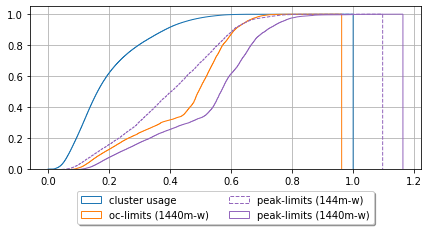

In [155]:

alpha_beta = range(0,int(capacity_planning_interval))


cluster_utilisation = cluster_usage.iloc[alpha_beta][funcs].sum(axis=1).reset_index()[0]
(cluster_utilisation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='cluster usage',color="tab:blue",figsize=(7,3)) 

linestyles= ["--","solid"]

for i, peak_limits in enumerate(oc_limits_cpu_per_window[:]):    
    cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[alpha_beta]).sum(axis=1)
    (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'oc-limits (1440m-w)',color='tab:orange')


for i, peak_limits in enumerate(peak_limits_cpu_per_window[:]):    
    cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[alpha_beta]).sum(axis=1)
    (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'peak-limits ({tau_windows[i]}m-w)',linestyle=linestyles[i],color='tab:purple')


linestyles= ["--","solid"]


plt.legend(loc='upper left')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.savefig("/local/scratch/phd-figures/peak-vs-oc-limits-cpu.pdf", format="pdf", bbox_inches="tight")


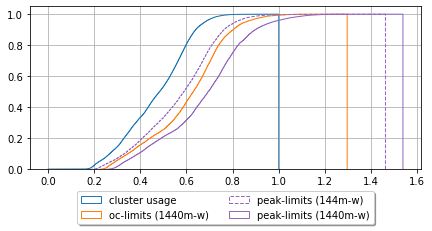

In [156]:

cluster_utilisation = cluster_usage_mem.iloc[0:capacity_planning_interval][funcs].sum(axis=1).reset_index()[0]
(cluster_utilisation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='cluster usage',color="tab:blue",figsize=(7,3)) 

linestyles= ["--","solid"]

for i, peak_limits in enumerate(oc_limits_mem_per_window[:]):    
    cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[alpha_beta]).sum(axis=1)
    (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'oc-limits (1440m-w)',color='tab:orange')


for i, peak_limits in enumerate(peak_limits_mem_per_window[:]):    
    cluster_allocation = (peak_limits[funcs].reset_index() * dfinstances_multipledays[funcs].reset_index()[funcs].iloc[alpha_beta]).sum(axis=1)
    (cluster_allocation/cluster_utilisation.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label=f'peak-limits ({tau_windows[i]}m-w)',linestyle=linestyles[i],color='tab:purple')


linestyles= ["--","solid"]


plt.legend(loc='upper left')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=2)

plt.savefig("/local/scratch/phd-figures/peak-vs-oc-limits-mem.pdf", format="pdf", bbox_inches="tight")


# Baseline capacity requirements

In [25]:
day_numbers = [int(re.findall("day_(\d+).*",day)[0]) for day in dataset_all]
day_numbers

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
 206,
 207,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234]

In [14]:
cluster_utilisation.index, 203040/1440

(RangeIndex(start=0, stop=203040, step=1), 141.0)

In [15]:
minute_index = np.array([[x+(int(day)*1440) for x in range(1440)] for day in day_numbers]).flatten()
len(minute_index)

203040

In [16]:
cluster_utilisation_indexed = cluster_utilisation.reset_index().set_index(minute_index)[0]
cluster_utilisation_indexed

0          62.976585
1          69.249805
2          68.157845
3          77.049600
4          90.050000
             ...    
338395    173.237230
338396    159.638580
338397    151.540760
338398    156.799250
338399    168.768066
Name: 0, Length: 203040, dtype: float64

In [20]:
peak_point1 = cluster_utilisation_indexed.loc[:118*1440].idxmax()
peak_point2 = cluster_utilisation_indexed.loc[118*1440:].idxmax()

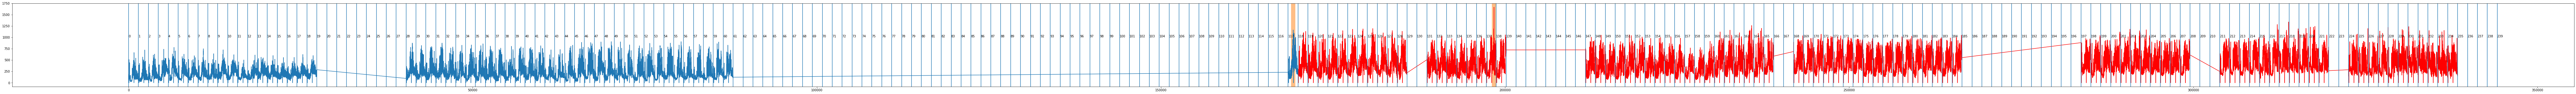

In [21]:
cluster_utilisation_indexed.loc[:118*1440].plot(figsize=(150,5))
cluster_utilisation_indexed.loc[118*1440:].plot(figsize=(150,5),color='red')

# cluster_utilisation_interpolated.interpolate().plot(x='minute',y='usage',figsize=(150,5))

plt.axvspan(peak_point1+300, peak_point1-300, facecolor='tab:orange', alpha=0.5)
plt.axvspan(peak_point2+300, peak_point2-300, facecolor='tab:orange', alpha=0.5)


for d in range(240):
    plt.axvline(x=d*1440)
    plt.text(d*1440, 1000, d, fontsize = 10, wrap=True,ha='left')     


In [145]:
day_numbers[39], day_numbers[39:40]

(48, [48])

In [105]:
day_numbers[52], day_numbers[52:53]

(117, [117])

In [195]:
day_numbers[55], day_numbers[55:56]

(120, [120])

In [106]:
day_numbers[70], day_numbers[70:71]

(137, [137])

In [29]:
(peak_point2 - peak_point1)/1440

20.26736111111111

In [202]:
for index, day in enumerate(days):
    print(index, get_ideal_capacity(days[index],1))

active_funcs_during_peak (1m) 93
0 18
active_funcs_during_peak (1m) 92
1 20
active_funcs_during_peak (1m) 93
2 19
active_funcs_during_peak (1m) 93
3 19
active_funcs_during_peak (1m) 93
4 22
active_funcs_during_peak (1m) 87
5 20
active_funcs_during_peak (1m) 93
6 19
active_funcs_during_peak (1m) 93
7 21
active_funcs_during_peak (1m) 93
8 18
active_funcs_during_peak (1m) 93
9 19
active_funcs_during_peak (1m) 93
10 19
active_funcs_during_peak (1m) 93
11 16
active_funcs_during_peak (1m) 93
12 17
active_funcs_during_peak (1m) 92
13 19
active_funcs_during_peak (1m) 91
14 18
active_funcs_during_peak (1m) 91
15 18
active_funcs_during_peak (1m) 92
16 16
active_funcs_during_peak (1m) 95
17 18
active_funcs_during_peak (1m) 96
18 19
active_funcs_during_peak (1m) 96
19 21
active_funcs_during_peak (1m) 96
20 21
active_funcs_during_peak (1m) 96
21 21
active_funcs_during_peak (1m) 96
22 21
active_funcs_during_peak (1m) 96
23 19
active_funcs_during_peak (1m) 96
24 19
active_funcs_during_peak (1m) 96
25

# Dominant resource

In [48]:
234/2

117.0

In [45]:
day_numbers[0], day_numbers[52], day_numbers[:53][-1], 117-0+1

(0, 117, 117, 118)

In [44]:
day_numbers[53], day_numbers[-1], 234-118+1

(118, 234, 117)

In [158]:
dist_sum_cpu_usage = []
dist_sum_mem_usage = []
dist_sum_cpu_allocation = []
dist_sum_mem_allocation = []

dist_sum_cpu_allocation_peak = []
dist_sum_mem_allocation_peak = []

dist_sum_cpu_allocation_oc = []
dist_sum_mem_allocation_oc = []


for index, day_data in enumerate(days):
    
    dfinstances, dfcpu_usage, dfcpu_limit, dfmem_usage, dfmem_limit = day_data
    
    dfcluster_cpu_usage = (dfinstances * dfcpu_usage* dfcpu_limit)[funcs]
    dfcluster_mem_usage = (dfinstances * dfmem_usage* dfmem_limit)[funcs]
    
    dfcluster_cpu_allocation = (dfinstances * dfcpu_limit)[funcs]
    dfcluster_mem_allocation = (dfinstances * dfmem_limit)[funcs]  

    sum_cpu_usage = dfcluster_cpu_usage.sum(axis=1)
    sum_mem_usage = dfcluster_mem_usage.sum(axis=1)
    dist_sum_cpu_usage.append(sum_cpu_usage)
    dist_sum_mem_usage.append(sum_mem_usage) 
    
    sum_cpu_allocation = dfcluster_cpu_allocation.sum(axis=1)
    sum_mem_allocation = dfcluster_mem_allocation.sum(axis=1)
    dist_sum_cpu_allocation.append(sum_cpu_allocation)
    dist_sum_mem_allocation.append(sum_mem_allocation)  
    
    
    sum_cpu_allocation_peak = dfcluster_cpu_usage.quantile(1).sum()
    sum_mem_allocation_peak = dfcluster_mem_usage.quantile(1).sum()
    
    dist_sum_cpu_allocation_peak.append(sum_cpu_allocation_peak)
    dist_sum_cpu_allocation_peak.append(sum_mem_allocation_peak)   
    
    sum_cpu_allocation_oc = dfcluster_cpu_usage.quantile(0.99).sum()
    sum_mem_allocation_oc = dfcluster_mem_usage.quantile(0.99).sum()
    dist_sum_cpu_allocation_oc.append(sum_cpu_allocation_oc)
    dist_sum_cpu_allocation_oc.append(sum_mem_allocation_oc)      
    
    

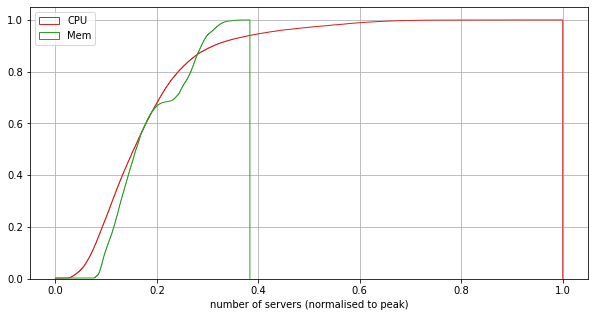

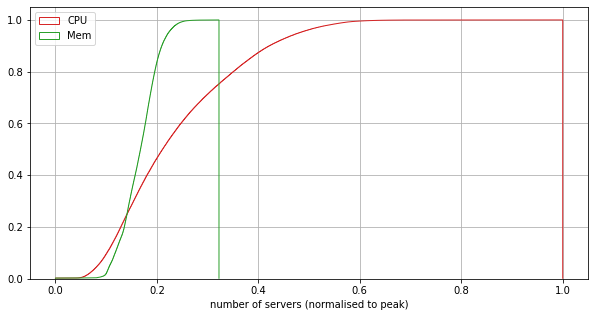

In [160]:
server_count_cpu_1st = (pd.concat(dist_sum_cpu_usage[:53])/server_cpu_capacity)
server_count_mem_1st = (pd.concat(dist_sum_mem_usage[:53])/server_mem_capacity)

(server_count_cpu_1st/server_count_cpu_1st.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='CPU', color='tab:red',figsize=(10,5)) 
(server_count_mem_1st/server_count_cpu_1st.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='Mem', color='tab:green') 
# plt.title('Cluster utilisation (planning window 0-120)')
plt.xlabel('number of servers (normalised to peak)')
plt.legend(loc='upper left')
# plt.xlim(0,36)


# plt.savefig("/local/scratch/phd-figures/dominant-resource-window1.pdf", format="pdf", bbox_inches="tight")
plt.show()


server_count_cpu_1st = (pd.concat(dist_sum_cpu_usage[53:])/server_cpu_capacity)
server_count_mem_1st = (pd.concat(dist_sum_mem_usage[53:])/server_mem_capacity)

(server_count_cpu_1st/server_count_cpu_1st.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='CPU', color='tab:red',figsize=(10,5)) 
(server_count_mem_1st/server_count_cpu_1st.max()).hist(histtype='step',cumulative=True,density=1,bins=1000,label='Mem', color='tab:green') 
# plt.title('Cluster utilisation (planning window 0-120)')
plt.xlabel('number of servers (normalised to peak)')
plt.legend(loc='upper left')
# plt.xlim(0,36)


# plt.savefig("/local/scratch/phd-figures/dominant-resource-window2.pdf", format="pdf", bbox_inches="tight")
plt.show()



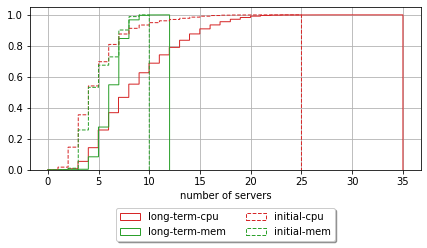

In [228]:

server_count_cpu_2nd = (pd.concat(dist_sum_cpu_usage[53:])/server_cpu_capacity).apply(np.ceil)
server_count_mem_2nd = (pd.concat(dist_sum_mem_usage[53:])/server_mem_capacity).apply(np.ceil)

(server_count_cpu_2nd).hist(histtype='step',cumulative=True,density=1,bins=1000,label='long-term-cpu', color='tab:red', figsize=(7,3)) 
(server_count_mem_2nd).hist(histtype='step',cumulative=True,density=1,bins=1000,label='long-term-mem', color='tab:green') 
plt.xlabel('number of servers (normalised to peak)')

server_count_cpu_1st = (pd.concat(dist_sum_cpu_usage[:53])/server_cpu_capacity).apply(np.ceil)
server_count_mem_1st = (pd.concat(dist_sum_mem_usage[:53])/server_mem_capacity).apply(np.ceil)

(server_count_cpu_1st).hist(histtype='step',cumulative=True,density=1,bins=1000,label='initial-cpu', color='tab:red',linestyle="--") 
(server_count_mem_1st).hist(histtype='step',cumulative=True,density=1,bins=1000,label='initial-mem', color='tab:green',linestyle="--") 
plt.xlabel('number of servers')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.savefig("/local/scratch/phd-figures/workload-growth.pdf", format="pdf", bbox_inches="tight")


plt.show()



0      NaN
1      1.0
2      NaN
3      NaN
4      NaN
      ... 
195    4.0
196    NaN
197    NaN
198    NaN
199    1.0
Name: 70142, Length: 200, dtype: float64

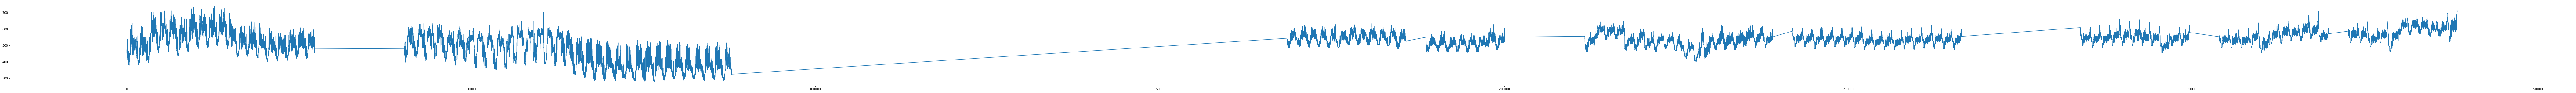

In [360]:
dfinstances_multipledays[funcs].set_index(minute_index).sum(axis=1).plot(figsize=(150,5))
dfinstances_multipledays[funcs].set_index(minute_index).loc[peak_point1]

In [406]:
active_funcs_during_peak_point1 = dfinstances_multipledays[funcs].set_index(minute_index).loc[peak_point1].dropna().index
len(active_funcs_during_peak_point1), active_funcs_during_peak_point1

(97,
 Index(['1', '6', '11', '12', '14', '15', '16', '25', '27', '28', '30', '31',
        '33', '34', '38', '39', '40', '44', '45', '51', '53', '59', '60', '65',
        '66', '67', '71', '72', '73', '75', '81', '86', '87', '88', '89', '90',
        '91', '92', '93', '94', '95', '96', '97', '100', '103', '104', '105',
        '107', '108', '109', '115', '116', '118', '119', '122', '126', '127',
        '128', '129', '130', '131', '132', '133', '134', '135', '138', '139',
        '146', '147', '148', '149', '150', '155', '156', '157', '160', '161',
        '164', '165', '166', '167', '168', '169', '170', '171', '174', '178',
        '179', '183', '187', '188', '189', '190', '194', '195', '198', '199'],
       dtype='object'))

In [407]:
dfinstances_during_peak1 = dfinstances_multipledays[funcs].set_index(minute_index).loc[peak_point1].dropna()

allreplicas_allocation_oc = []
allreplicas_allocation_vs = []

for func in active_funcs_during_peak_point1:
    replicas_at_peak = int(dfinstances_during_peak1[func])

    for r in range(int(replicas_at_peak)):
        allreplicas_allocation_oc.append(oc_limits_cpu_per_window[0][[func]].set_index(minute_index)[func])
        allreplicas_allocation_vs.append(peak_limits_cpu_per_window[1][[func]].set_index(minute_index)[func])
        
dfcpu_limit_replicas_oc = pd.concat(allreplicas_allocation_oc,axis=1)
dfcpu_limit_replicas_vs = pd.concat(allreplicas_allocation_vs,axis=1)

bp_input = dfcpu_limit_replicas_oc.set_index(minute_index).loc[peak_point1]
bp_output_oc = binpacking.to_constant_volume(bp_input,server_cpu_capacity)
print(len(bp_output_oc))

bp_input = dfcpu_limit_replicas_vs.set_index(minute_index).loc[peak_point1]
bp_output_vs = binpacking.to_constant_volume(bp_input,server_cpu_capacity)
len(bp_output_vs)

23


27

In [409]:
active_funcs_during_peak_point2 = dfinstances_multipledays[funcs].set_index(minute_index).loc[peak_point2].dropna().index
len(active_funcs_during_peak_point2), active_funcs_during_peak_point2

(99,
 Index(['1', '2', '6', '11', '12', '15', '16', '17', '19', '20', '25', '26',
        '27', '28', '31', '33', '34', '35', '36', '38', '39', '40', '45', '46',
        '47', '51', '59', '60', '61', '62', '64', '65', '66', '67', '70', '71',
        '72', '73', '75', '80', '85', '86', '87', '88', '89', '90', '91', '92',
        '93', '94', '95', '96', '97', '98', '99', '100', '104', '105', '108',
        '116', '118', '119', '126', '129', '130', '131', '132', '133', '134',
        '135', '140', '141', '143', '144', '146', '147', '148', '150', '155',
        '156', '157', '160', '161', '164', '168', '169', '170', '171', '174',
        '179', '183', '185', '186', '187', '188', '189', '194', '195', '199'],
       dtype='object'))

In [410]:
dfinstances_during_peak2 = dfinstances_multipledays[funcs].set_index(minute_index).loc[peak_point2].dropna()

allreplicas_allocation_oc = []
allreplicas_allocation_vs = []

for func in active_funcs_during_peak_point2:
    replicas_at_peak = int(dfinstances_during_peak2[func])

    for r in range(int(replicas_at_peak)):
        allreplicas_allocation_oc.append(oc_limits_cpu_per_window[0][[func]].set_index(minute_index)[func])
        allreplicas_allocation_vs.append(peak_limits_cpu_per_window[1][[func]].set_index(minute_index)[func])
        
dfcpu_limit_replicas_oc = pd.concat(allreplicas_allocation_oc,axis=1)
dfcpu_limit_replicas_vs = pd.concat(allreplicas_allocation_vs,axis=1)

bp_input = dfcpu_limit_replicas_oc.set_index(minute_index).loc[peak_point2]
bp_output_oc = binpacking.to_constant_volume(bp_input,server_cpu_capacity)
print(len(bp_output_oc))

bp_input = dfcpu_limit_replicas_vs.set_index(minute_index).loc[peak_point2]
bp_output_vs = binpacking.to_constant_volume(bp_input,server_cpu_capacity)
len(bp_output_vs)

26


32

# Overcommitment capacity requirements

In [16]:
def replicas(dfinstances, dfusage, dflimit):

    cluster_usage = (dfinstances * dfusage* dflimit)[funcs]
    clusetr_allocation = (dfinstances * dflimit)[funcs]
    replica_usage = cluster_usage[funcs] / dfinstances[funcs]
    replica_allocation = clusetr_allocation[funcs] / dfinstances[funcs]

    peak_point = cluster_usage.sum(axis=1).idxmax() 
    active_funcs_during_peak = dfinstances[funcs].iloc[peak_point].dropna().index
    print('active_funcs_during_peak (1m)', len(active_funcs_during_peak))
    instances_during_peak = dfinstances[funcs].iloc[peak_point].dropna().values
    dfinstances_during_peak = dfinstances[funcs].iloc[peak_point].dropna()

    allreplicas_usage = []
    allreplicas_allocation = []
    for func in active_funcs_during_peak:
        replicas_at_peak = int(dfinstances_during_peak[func])

        for r in range(int(replicas_at_peak)):
            allreplicas_usage.append(replica_usage[[func]])
            allreplicas_allocation.append(replica_allocation[[func]])
            
    return pd.concat(allreplicas_usage,axis=1), pd.concat(allreplicas_allocation,axis=1)

def get_ideal_capacity(day_data, q):
    
    dfinstances, dfcpu_usage, dfcpu_limit, dfmem_usage, dfmem_limit = day_data    
    dfcpu_usage_replicas, dfcpu_limit_replicas  = replicas(dfinstances, dfcpu_usage, dfcpu_limit)
#     dfmem_usage_replicas, dfmem_limit_replicas  = replicas(dfinstances, dfmem_usage, dfmem_limit)  

    cluster_usage = (dfinstances * dfcpu_usage* dfcpu_limit)[funcs]
    peak_point = cluster_usage.sum(axis=1).idxmax()       
    
    #strict bin packing estimations
    active_funcs_during_peak = dfinstances[funcs].iloc[peak_point].dropna().index
    peaks_given_24h = dfcpu_usage_replicas[active_funcs_during_peak].quantile(q)
    binpacked_bestfit = binpacking.to_constant_volume(peaks_given_24h,server_cpu_capacity)
    ideal_capacity = len(binpacked_bestfit)    
#     print(q, len(binpacked_bestfit), "bestfit bin packing")  
    
    return ideal_capacity

def simulate_load(replica_usage, allpeaks_given_24h, binpacked_loadbalanced,visualise=False):
#     replica_usage = cluster_usage[funcs] / dfinstances[funcs]
    
    cluster_size = len(binpacked_loadbalanced)
    nodes = []
    
    for index, node in enumerate(binpacked_loadbalanced):
        instances_per_node = node.keys()
        funcs_per_node = [allpeaks_given_24h.iloc[instance]['func'] for instance in instances_per_node]
        
        dfs = []
        for func in funcs_per_node:
            shape = replica_usage[func].shape
            if(len(shape)>1):
                df = replica_usage[func].max(axis=1)
            else:
                df = replica_usage[func]
            dfs.append(df)
        
        if (visualise):
            plt.axhline(1)
            (pd.concat(dfs,axis=1).sum(axis=1)/server_cpu_capacity).plot(figsize=(15,5),title=f"Per node utilisation ({cluster_size} nodes)")
        
        nodes.append(pd.concat(dfs,axis=1))    
        
    if (visualise):
        plt.show()    
    
    return nodes

    
def simulate_day(day_data,quantiles):
    
    
    dfinstances, dfcpu_usage, dfcpu_limit, dfmem_usage, dfmem_limit = day_data
    
    dfcpu_usage_replicas, dfcpu_limit_replicas  = replicas(dfinstances, dfcpu_usage, dfcpu_limit)
#     dfmem_usage_replicas, dfmem_limit_replicas  = replicas(dfinstances, dfmem_usage, dfmem_limit)  
#     cluster_usage = (dfinstances * dfcpu_usage* dfcpu_limit)[funcs]
#     peak_point = cluster_usage.sum(axis=1).idxmax()    

    replica_usage = dfcpu_usage * dfcpu_limit

    all_violations = []
    all_utils = []
    per_day_util = []    

    simulation_data_bestfit = []
    simulation_data_loadbalanced = []

    processed_data = []

    for q in quantiles:

        #strict bin packing estimations
        ideal_capacity = get_ideal_capacity(day_data,q)

        #simulating day-long utilisation and overload 
        allpeaks_given_24h = dfcpu_usage_replicas.quantile(q)
        allpeaks_given_24h = allpeaks_given_24h.reset_index()
        allpeaks_given_24h.columns = ['func','peak']    
        peaks = allpeaks_given_24h['peak'].to_dict()

        binpacked_loadbalanced = binpacking.to_constant_bin_number(peaks,ideal_capacity)    
        cluster_nodes_util = simulate_load(replica_usage,allpeaks_given_24h, binpacked_loadbalanced)
        simulation_data_loadbalanced.append(cluster_nodes_util)

        binpacked_bestfit = binpacking.to_constant_volume(peaks,server_cpu_capacity)    
        cluster_nodes_util = simulate_load(replica_usage,allpeaks_given_24h, binpacked_bestfit)  
        simulation_data_bestfit.append(cluster_nodes_util)
    
    return simulation_data_loadbalanced, simulation_data_bestfit

#     processed_data.append(df_loadbalanced, df_bestfit)
    


In [22]:
def plot_util(df_loadbalanced):

    p = df_loadbalanced.plot.bar(y='cluster_size',color="tab:blue",legend=False)
    # p.legend(loc='upper left')
    p.set_xlabel('RC percentile')
    p.set_ylabel('Cluster size (normailised)')
    p.tick_params(axis='y', colors='tab:blue')

    twin = p.twinx()
    twin.tick_params(axis='y', colors='tab:green')
    twin.yaxis.label.set_color('tab:green')

    df_loadbalanced.plot(y='cluster_daily_utilisation',ax=twin,color='tab:green',ylabel='Average daily utilisation',legend=False)
    df_loadbalanced.plot(y='cluster_daily_utilisation_peak',ax=twin,color='tab:red',legend=False)
    # twin.legend(loc='upper right')


    # ax.set_xticks([0,2,4,6])
    twin.set_xticklabels(quantiles)
    
    return p,twin

# plot_util(df_loadbalanced)

def plot_overload_frequency(df_loadbalanced, df_bestfit):
    p = df_loadbalanced.plot.bar(y='cluster_size',color="tab:purple",legend=False,label='cluster size')
    # p.legend(loc='upper left')
    p.set_xlabel('RC percentile')

    p.set_ylabel('Cluster size reduction (normailised)')
    p.tick_params(axis='y', colors='tab:blue')

    twin = p.twinx()
    
    twin.tick_params(axis='y', colors='tab:red')
    twin.yaxis.label.set_color('tab:red')
    twin.set_xticklabels(quantiles)
#     twin.set_yticks([0.01 * x for x in range(20)])

    df_loadbalanced.plot(y='overload_frequency',ax=twin,color='orange',ylabel='Overload frequency',legend=False,label='overload frequency (worst-fit)')
    # twin.legend(loc='upper right')

    df_bestfit.plot(y='overload_frequency',ax=twin,color='red',legend=False,label='overload frequency (best-fit)')
    
    return p, twin
    # twin.legend(loc='upper right')

# plot_overload(df_loadbalanced, df_bestfit)

def plot_overload_severity(df_loadbalanced, df_bestfit):
    p = df_loadbalanced.plot.bar(y='cluster_size',color="tab:purple",legend=False)
    # p.legend(loc='upper left')
    p.set_xlabel('RC percentile')
    

    p.set_ylabel('Cluster size reduction (normailised)')
    p.tick_params(axis='y', colors='tab:blue')

    twin = p.twinx()
    
    twin.tick_params(axis='y', colors='tab:red')
    twin.yaxis.label.set_color('tab:red')
    twin.set_xticklabels(quantiles)
#     twin.set_yticks([0.01 * x for x in range(20)])

    df_loadbalanced.plot(y='cluster_daily_utilisation_peak',ax=twin,color='orange',ylabel='Overload severity',legend=False)
    # twin.legend(loc='upper right')

    df_bestfit.plot(y='cluster_daily_utilisation_peak',ax=twin,color='red',legend=False)
    
    return p, twin
    # twin.legend(loc='upper right')

# plot_overload(df_loadbalanced, df_bestfit)(0.05+ 99.95), 0.05 / 100


def process_simulation_data(simulation_data, quantiles, visualise=False):
    
    all_violations = []

    all_utils = []
    all_utils_peak = []
     
    for index, cluster_nodes_util in  enumerate(simulation_data):

        dfs = []
        for node in (cluster_nodes_util):
            dfs.append(node.sum(axis=1)/server_cpu_capacity)

        cluster_util = (pd.concat(dfs))
#         cluster_util.hist(histtype='step',cumulative=True,density=1,label=f"q-{quantiles[index]}",bins=1000)

        severity = cluster_util[cluster_util>1]
        
        if (visualise):
            plt.legend(loc='lower right')
            severity.hist(histtype='step',cumulative=True,density=1,label=f"q-{quantiles[index]}",bins=1000)
        
        violations = cluster_util.apply(lambda x : x> 1).value_counts()
        violations_rate = (1-(violations[False] / violations.sum()))

        all_violations.append(violations_rate)
        all_utils.append(cluster_util.mean())
        all_utils_peak.append(cluster_util.max())
        
        cluster_size = [len(nodes) for nodes in simulation_data]

        relative_cluster_size = [nodes / cluster_size[0] for nodes in cluster_size]

        savings = [int((1-size)*100) for size in relative_cluster_size] 

    # plt.show()

    if (visualise):
        plt.xlim(1,2.1)
        plt.show()

    # print(savings)


    df = pd.DataFrame({ 
        'rc-quantiles': quantiles, 
        'overload_frequency': all_violations, 
        'cluster_daily_utilisation': all_utils,
        'cluster_daily_utilisation_peak': all_utils_peak,
        'cluster_size': cluster_size,
        'cost': relative_cluster_size
    })         

    df['savings'] = 1 - df['cost']
    
    df['days'] = day_numbers
    
    dfi = pd.DataFrame()

    dfi['days'] = range(240)

    dfi['overload_frequency'] = df.set_index('days')['overload_frequency']
    
    dfi['cluster_daily_utilisation_peak'] = df.set_index('days')['cluster_daily_utilisation_peak']
    

    dfi = dfi.interpolate()
    
    df['slo_violation_0'] = df['overload_frequency'].apply(lambda x: x < 0.0005)
    df['slo_violation_1'] = df['overload_frequency'].apply(lambda x: (x >= 0.0005) and (x < 0.01))
    df['slo_violation_2'] = df['overload_frequency'].apply(lambda x: (x >= 0.01) and (x < 0.05))
    
#     display(dfi)
    
    return dfi
    
# df_loadbalanced = process_simulation_data(simulation_data_loadbalanced)
# df_bestfit = process_simulation_data(simulation_data_bestfit)


In [199]:

    
def process_simulation_data(simulation_data, quantiles, visualise=False):
    
    all_violations = []

    all_utils = []
    all_utils_peak = []
     
    for index, cluster_nodes_util in  enumerate(simulation_data):

        dfs = []
        for node in (cluster_nodes_util):
            dfs.append(node.sum(axis=1)/server_cpu_capacity)

        cluster_util = (pd.concat(dfs))
#         cluster_util.hist(histtype='step',cumulative=True,density=1,label=f"q-{quantiles[index]}",bins=1000)

        severity = cluster_util[cluster_util>1]
        
        if (visualise):
            plt.legend(loc='lower right')
            severity.hist(histtype='step',cumulative=True,density=1,label=f"q-{quantiles[index]}",bins=1000)
        
        violations = cluster_util.apply(lambda x : x> 1).value_counts()
        violations_rate = (1-(violations[False] / violations.sum()))

        all_violations.append(violations_rate)
        all_utils.append(cluster_util.mean())
        all_utils_peak.append(cluster_util.max())
        
        cluster_size = [len(nodes) for nodes in simulation_data]

        relative_cluster_size = [nodes / cluster_size[0] for nodes in cluster_size]

        savings = [int((1-size)*100) for size in relative_cluster_size] 

    # plt.show()

    if (visualise):
        plt.xlim(1,2.1)
        plt.show()

    # print(savings)


    df = pd.DataFrame({ 
        'rc-quantiles': quantiles, 
        'overload_frequency': all_violations, 
        'cluster_daily_utilisation': all_utils,
        'cluster_daily_utilisation_peak': all_utils_peak,
        'cluster_size': cluster_size,
        'cost': relative_cluster_size
    })         

    df['savings'] = 1 - df['cost']
        
    
    baseline = df['cluster_size'].max() - df['cluster_size'].min()
    df['growth_savings'] = 1-((df['cluster_size'] - df['cluster_size'].min()) / baseline) 
    
    
    df['slo_violation_0'] = df['overload_frequency'].apply(lambda x: x < 0.0005)
    df['slo_violation_1'] = df['overload_frequency'].apply(lambda x: (x >= 0.0005) and (x < 0.01))
    df['slo_violation_2'] = df['overload_frequency'].apply(lambda x: (x >= 0.01) and (x < 0.05))
    
    

    
    display(df)
    
    return df
    
# df_loadbalanced = process_simulation_data(simulation_data_loadbalanced)
# df_bestfit = process_simulation_data(simulation_data_bestfit)


['day_119.csv']
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.269753,0.858755,30,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.000000,0.299726,0.971790,27,0.900000,0.100000,0.500000,True,False,False
2,0.998,0.000000,0.299726,0.962591,27,0.900000,0.100000,0.500000,True,False,False
3,0.997,0.000321,0.311254,1.055215,26,0.866667,0.133333,0.666667,True,False,False
4,0.996,0.000294,0.311254,1.063928,26,0.866667,0.133333,0.666667,True,False,False
5,0.995,0.000321,0.311254,1.063913,26,0.866667,0.133333,0.666667,True,False,False
6,0.994,0.000000,0.311254,0.981018,26,0.866667,0.133333,0.666667,True,False,False
7,0.993,0.000000,0.311254,0.981570,26,0.866667,0.133333,0.666667,True,False,False
8,0.992,0.000000,0.323704,0.998996,25,0.833333,0.166667,0.833333,True,False,False
9,0.991,0.000028,0.323704,1.004259,25,0.833333,0.166667,0.833333,True,False,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.269753,0.984005,30,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.000206,0.299726,1.282384,27,0.900000,0.100000,0.500000,True,False,False
2,0.998,0.001440,0.299726,1.428279,27,0.900000,0.100000,0.500000,False,True,False
3,0.997,0.002110,0.311254,1.450437,26,0.866667,0.133333,0.666667,False,True,False
4,0.996,0.003018,0.311254,1.575876,26,0.866667,0.133333,0.666667,False,True,False
5,0.995,0.003045,0.311254,1.626182,26,0.866667,0.133333,0.666667,False,True,False
6,0.994,0.003766,0.311254,1.700476,26,0.866667,0.133333,0.666667,False,True,False
7,0.993,0.004327,0.311254,1.725220,26,0.866667,0.133333,0.666667,False,True,False
8,0.992,0.005083,0.323704,1.757670,25,0.833333,0.166667,0.833333,False,True,False
9,0.991,0.005667,0.323704,1.699647,25,0.833333,0.166667,0.833333,False,True,False


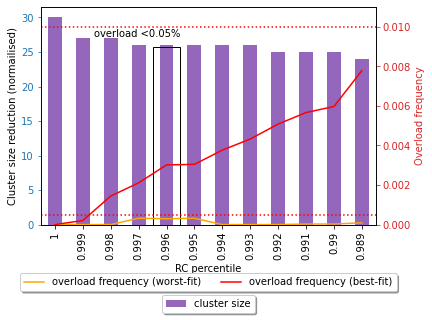

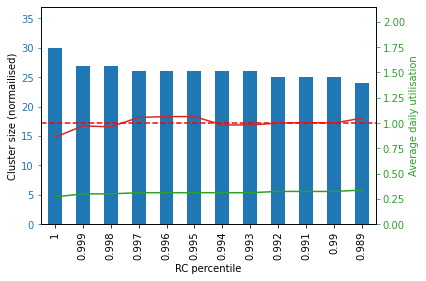

In [207]:
    
quantiles = [((100 - qi)/100) for qi in range(0,10+1+1)]

quantiles = [1,0.999,0.998,0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.990,0.989]
    
for index, day in enumerate(days[54:55]):
    
    print(dataset_all[54:55])
    
    simulation_data_loadbalanced, simulation_data_bestfit  = simulate_day(day, quantiles)
    
    df_loadbalanced_initial = process_simulation_data(simulation_data_loadbalanced, quantiles)
    df_bestfit_safe = process_simulation_data(simulation_data_bestfit,quantiles)   
    
    p, twin = plot_overload_frequency(df_loadbalanced_initial, df_bestfit_safe)

    from matplotlib.patches import Rectangle
    
#     p.set_xlim(0,0.4)
    
    
    twin.set_ylim(0,0.011)    
    
    twin.axhline(0.0005,linestyle=':',color='red')
    twin.axhline(0.01,linestyle=':',color='red')
#     twin.axhline(0.05,linestyle=':',color='red')  

    #add rectangle to plot
    twin.add_patch(Rectangle((4-0.5, 0), 1, 0.009,  
                    edgecolor='black',
                    facecolor='none',
                    lw=1))  
    
    twin.text(4+0.5, 0.0095, "overload <0.05%", fontsize = 10, wrap=True,ha='right')
    
    p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              fancybox=True, shadow=True, ncol=2)    
    
    twin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=2)

    plt.savefig("/local/scratch/phd-figures/oracle-oc-limits-initial-capacity.pdf", format="pdf", bbox_inches="tight")    
    
    plt.show()    
    p,twin = plot_util(df_loadbalanced_initial)
    
    p.set_ylim(0,37)
    twin.set_ylim(0,2.15)
    twin.axhline(1,color='red',linestyle="--")
    plt.show()    
    

['day_117.csv']
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97
active_funcs_during_peak (1m) 97


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.288554,0.953392,27,1.000000,0.000000,0.00,True,False,False
1,0.999,0.000000,0.299652,0.987940,26,0.962963,0.037037,0.25,True,False,False
2,0.998,0.000000,0.299652,0.980933,26,0.962963,0.037037,0.25,True,False,False
3,0.997,0.000361,0.311638,1.016557,25,0.925926,0.074074,0.50,True,False,False
4,0.996,0.000278,0.311638,1.014647,25,0.925926,0.074074,0.50,True,False,False
5,0.995,0.000492,0.324623,1.057232,24,0.888889,0.111111,0.75,True,False,False
6,0.994,0.000492,0.324623,1.064831,24,0.888889,0.111111,0.75,True,False,False
7,0.993,0.000463,0.324623,1.053156,24,0.888889,0.111111,0.75,True,False,False
8,0.992,0.000521,0.324623,1.052383,24,0.888889,0.111111,0.75,False,True,False
9,0.991,0.000492,0.324623,1.063528,24,0.888889,0.111111,0.75,True,False,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.288554,0.986527,27,1.000000,0.000000,0.00,True,False,False
1,0.999,0.000534,0.299652,1.117006,26,0.962963,0.037037,0.25,False,True,False
2,0.998,0.001389,0.299652,1.132193,26,0.962963,0.037037,0.25,False,True,False
3,0.997,0.001889,0.311638,1.139498,25,0.925926,0.074074,0.50,False,True,False
4,0.996,0.003000,0.311638,1.343448,25,0.925926,0.074074,0.50,False,True,False
5,0.995,0.003125,0.324623,1.383393,24,0.888889,0.111111,0.75,False,True,False
6,0.994,0.003733,0.324623,1.424457,24,0.888889,0.111111,0.75,False,True,False
7,0.993,0.004022,0.324623,1.365877,24,0.888889,0.111111,0.75,False,True,False
8,0.992,0.004456,0.324623,1.416329,24,0.888889,0.111111,0.75,False,True,False
9,0.991,0.005093,0.324623,1.434709,24,0.888889,0.111111,0.75,False,True,False


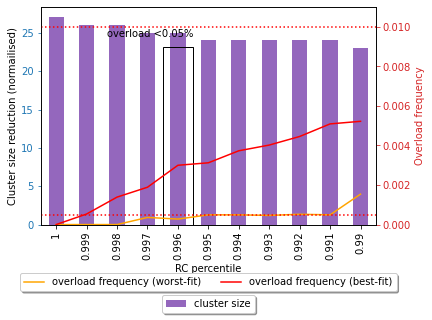

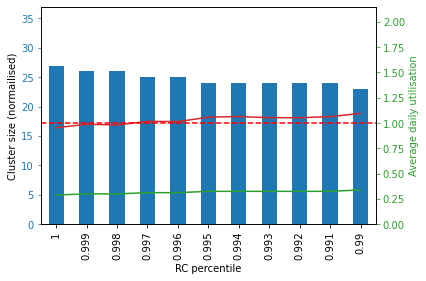

In [200]:
    
quantiles = [((100 - qi)/100) for qi in range(0,10+1+1)]

quantiles = [1,0.999,0.998,0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.99]
    
for index, day in enumerate(days[52:53]):
    
    print(dataset_all[52:53])
    
    simulation_data_loadbalanced, simulation_data_bestfit  = simulate_day(day, quantiles)
    
    df_loadbalanced_initial = process_simulation_data(simulation_data_loadbalanced, quantiles)
    df_bestfit_safe = process_simulation_data(simulation_data_bestfit,quantiles)   
    
    p, twin = plot_overload_frequency(df_loadbalanced_initial, df_bestfit_safe)

    from matplotlib.patches import Rectangle
    
#     p.set_xlim(0,0.4)
    
    
    twin.set_ylim(0,0.011)    
    
    twin.axhline(0.0005,linestyle=':',color='red')
    twin.axhline(0.01,linestyle=':',color='red')
#     twin.axhline(0.05,linestyle=':',color='red')  

    #add rectangle to plot
    twin.add_patch(Rectangle((4-0.5, 0), 1, 0.009,  
                    edgecolor='black',
                    facecolor='none',
                    lw=1))  
    
    twin.text(4+0.5, 0.0095, "overload <0.05%", fontsize = 10, wrap=True,ha='right')
    
    p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              fancybox=True, shadow=True, ncol=2)    
    
    twin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=2)

    plt.savefig("/local/scratch/phd-figures/oracle-oc-limits-initial-capacity.pdf", format="pdf", bbox_inches="tight")    
    
    plt.show()    
    p,twin = plot_util(df_loadbalanced_initial)
    
    p.set_ylim(0,37)
    twin.set_ylim(0,2.15)
    twin.axhline(1,color='red',linestyle="--")
    plt.show()    
    

['day_137.csv']
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98
active_funcs_during_peak (1m) 98


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.233173,0.982143,36,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.000694,0.289456,1.246744,29,0.805556,0.194444,0.538462,False,True,False
2,0.998,0.000908,0.322855,1.395699,26,0.722222,0.277778,0.769231,False,True,False
3,0.997,0.001139,0.335769,1.447130,25,0.694444,0.305556,0.846154,False,True,False
4,0.996,0.001302,0.349760,1.509130,24,0.666667,0.333333,0.923077,False,True,False
5,0.995,0.001244,0.349760,1.498470,24,0.666667,0.333333,0.923077,False,True,False
6,0.994,0.001215,0.349760,1.484883,24,0.666667,0.333333,0.923077,False,True,False
7,0.993,0.001186,0.349760,1.492854,24,0.666667,0.333333,0.923077,False,True,False
8,0.992,0.001157,0.349760,1.493766,24,0.666667,0.333333,0.923077,False,True,False
9,0.991,0.001691,0.364967,1.561840,23,0.638889,0.361111,1.000000,False,True,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.233173,0.999984,36,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.001149,0.289456,1.650445,29,0.805556,0.194444,0.538462,False,True,False
2,0.998,0.001549,0.322855,1.799764,26,0.722222,0.277778,0.769231,False,True,False
3,0.997,0.002278,0.335769,1.869286,25,0.694444,0.305556,0.846154,False,True,False
4,0.996,0.002546,0.349760,2.007921,24,0.666667,0.333333,0.923077,False,True,False
5,0.995,0.003848,0.349760,2.013891,24,0.666667,0.333333,0.923077,False,True,False
6,0.994,0.004138,0.349760,2.054679,24,0.666667,0.333333,0.923077,False,True,False
7,0.993,0.005498,0.349760,2.092350,24,0.666667,0.333333,0.923077,False,True,False
8,0.992,0.006019,0.349760,2.110103,24,0.666667,0.333333,0.923077,False,True,False
9,0.991,0.007367,0.364967,2.066925,23,0.638889,0.361111,1.000000,False,True,False


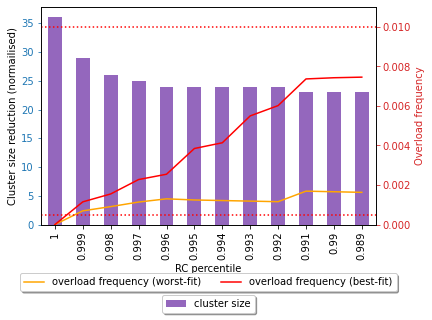

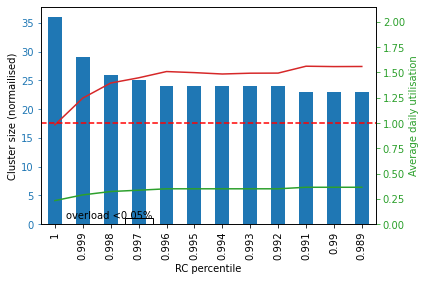

In [215]:
    
quantiles = [((100 - qi)/100) for qi in range(0,10+1+1)]

quantiles = [1,0.999,0.998,0.997, 0.996, 0.995, 0.994, 0.993, 0.992, 0.991, 0.990,0.989]
    
for index, day in enumerate(days[70:71]):
    
    print(dataset_all[70:71])
    
    simulation_data_loadbalanced, simulation_data_bestfit  = simulate_day(day, quantiles)
    
    df_loadbalanced_long_term = process_simulation_data(simulation_data_loadbalanced, quantiles)
    df_bestfit_safe = process_simulation_data(simulation_data_bestfit,quantiles)   
    
    p, twin = plot_overload_frequency(df_loadbalanced_long_term, df_bestfit_safe)
    
#     p.set_xlim(0,0.4)

    from matplotlib.patches import Rectangle
    
    twin.set_ylim(0,0.011)    
    
    twin.axhline(0.0005,linestyle=':',color='red')
    twin.axhline(0.01,linestyle=':',color='red')
#     twin.axhline(0.05,linestyle=':',color='red')  

    #add rectangle to plot

    
    
    p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
              fancybox=True, shadow=True, ncol=2)    
    
    twin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=2)

    plt.savefig("/local/scratch/phd-figures/oracle-oc-limits-initial-capacity.pdf", format="pdf", bbox_inches="tight")    
    
    plt.show()    
    p,twin = plot_util(df_loadbalanced_long_term)
    twin.set_ylim(0,2.15)
    twin.axhline(1,color='red',linestyle="--")
    
    p.text(3+0.5, 1, "overload <0.05%", fontsize = 10, wrap=True,ha='right')
    p.add_patch(Rectangle((3-0.5, 0), 1, 1,  
                    edgecolor='black',
                    facecolor='none',
                    lw=1))      
    
    
    plt.show()    
    

In [21]:
def simulate_multiple_days(days_data,q,ideal_capacity=None):
    
    if ideal_capacity == None:
        ideal_capacity = get_ideal_capacity(days[52],q)
    
    all_violations = []
    all_utils = []
    per_day_util = []    

    simulation_data_random = []
    simulation_data_loadbalanced = []

    processed_data = []    
    
    for index, day_data in enumerate(days_data):
        
        print("capacity", ideal_capacity, "day", index,"\n")
    
        dfinstances, dfcpu_usage, dfcpu_limit, dfmem_usage, dfmem_limit = day_data
        
        replica_usage = dfcpu_usage * dfcpu_limit

        dfcpu_usage_replicas, dfcpu_limit_replicas  = replicas(dfinstances, dfcpu_usage, dfcpu_limit)
    #     dfmem_usage_replicas, dfmem_limit_replicas  = replicas(dfinstances, dfmem_usage, dfmem_limit)  
    #     cluster_usage = (dfinstances * dfcpu_usage* dfcpu_limit)[funcs]
    #     peak_point = cluster_usage.sum(axis=1).idxmax()     

        #simulating day-long utilisation and overload 
        allpeaks_given_24h = dfcpu_usage_replicas.quantile(1)
        allpeaks_given_24h = allpeaks_given_24h.reset_index()
        allpeaks_given_24h.columns = ['func','peak']    
        peaks = allpeaks_given_24h['peak'].to_dict()

        binpacked_loadbalanced = binpacking.to_constant_bin_number(peaks,ideal_capacity)    
        cluster_nodes_util = simulate_load(replica_usage,allpeaks_given_24h, binpacked_loadbalanced)
        simulation_data_loadbalanced.append(cluster_nodes_util)

#         binpacked_random = binpacking_randomly(allpeaks_given_24h,ideal_capacity)    
#         cluster_nodes_util = simulate_load(replica_usage,allpeaks_given_24h, binpacked_random)  
#         simulation_data_random.append(cluster_nodes_util)
        
    
#     return simulation_data_random
    
    return simulation_data_loadbalanced

#     processed_data.append(df_loadbalanced, df_bestfit)

In [44]:
import pickle

import multiprocessing, time
t0 = time.time()
simulation_data = []

def store_data(ideal_capacity, output):
    print('called')
    # open a file, where you ant to store the data
    filename = f'/local/scratch/simulation/capacity-{ideal_capacity}-lb'
    file = open(filename, 'wb')

    # dump information to that file
    pickle.dump(output, file)
    
    print("stored to", filename)
    
    # close the file
    file.close()
    
def network_call(ideal_capacity):
    output = simulate_multiple_days(days[:141],1,ideal_capacity=ideal_capacity)
    store_data(ideal_capacity, output)
    
for capacity in range(36,37,1):
    multiprocessing.Process(target=network_call,args=(capacity,)).start()

capacity 36 day 0 

active_funcs_during_peak (1m) 93
capacity 36 day 1 

active_funcs_during_peak (1m) 92
capacity 36 day 2 

active_funcs_during_peak (1m) 93
capacity 36 day 3 

active_funcs_during_peak (1m) 93
capacity 36 day 4 

active_funcs_during_peak (1m) 93
capacity 36 day 5 

active_funcs_during_peak (1m) 87
capacity 36 day 6 

active_funcs_during_peak (1m) 93
capacity 36 day 7 

active_funcs_during_peak (1m) 93
capacity 36 day 8 

active_funcs_during_peak (1m) 93
capacity 36 day 9 

active_funcs_during_peak (1m) 93
capacity 36 day 10 

active_funcs_during_peak (1m) 93
capacity 36 day 11 

active_funcs_during_peak (1m) 93
capacity 36 day 12 

active_funcs_during_peak (1m) 93
capacity 36 day 13 

active_funcs_during_peak (1m) 92
capacity 36 day 14 

active_funcs_during_peak (1m) 91
capacity 36 day 15 

active_funcs_during_peak (1m) 91
capacity 36 day 16 

active_funcs_during_peak (1m) 92
capacity 36 day 17 

active_funcs_during_peak (1m) 95
capacity 36 day 18 

active_funcs_duri

In [ ]:
for i in range(141):
    print(i,get_ideal_capacity(days[i],1))

In [ ]:
19 / 22

In [280]:
dq_output = simulate_multiple_days(days[19:51],1,ideal_capacity=19)

capacity 19 day 0 

active_funcs_during_peak (1m) 96
capacity 19 day 1 

active_funcs_during_peak (1m) 96
capacity 19 day 2 

active_funcs_during_peak (1m) 96
capacity 19 day 3 

active_funcs_during_peak (1m) 96
capacity 19 day 4 

active_funcs_during_peak (1m) 96
capacity 19 day 5 

active_funcs_during_peak (1m) 96
capacity 19 day 6 

active_funcs_during_peak (1m) 96
capacity 19 day 7 

active_funcs_during_peak (1m) 94
capacity 19 day 8 

active_funcs_during_peak (1m) 94
capacity 19 day 9 

active_funcs_during_peak (1m) 95
capacity 19 day 10 

active_funcs_during_peak (1m) 96
capacity 19 day 11 

active_funcs_during_peak (1m) 95
capacity 19 day 12 

active_funcs_during_peak (1m) 96
capacity 19 day 13 

active_funcs_during_peak (1m) 94
capacity 19 day 14 

active_funcs_during_peak (1m) 94
capacity 19 day 15 

active_funcs_during_peak (1m) 94
capacity 19 day 16 

active_funcs_during_peak (1m) 96
capacity 19 day 17 

active_funcs_during_peak (1m) 94
capacity 19 day 18 

active_funcs_duri

capacity 18 day 0 

active_funcs_during_peak (1m) 96
capacity 18 day 1 

active_funcs_during_peak (1m) 96
capacity 18 day 2 

active_funcs_during_peak (1m) 96
capacity 18 day 3 

active_funcs_during_peak (1m) 96
capacity 18 day 4 

active_funcs_during_peak (1m) 96
capacity 18 day 5 

active_funcs_during_peak (1m) 96
capacity 18 day 6 

active_funcs_during_peak (1m) 96
capacity 18 day 7 

active_funcs_during_peak (1m) 94
capacity 18 day 8 

active_funcs_during_peak (1m) 94
capacity 18 day 9 

active_funcs_during_peak (1m) 95
capacity 18 day 10 

active_funcs_during_peak (1m) 96
capacity 18 day 11 

active_funcs_during_peak (1m) 95
capacity 18 day 12 

active_funcs_during_peak (1m) 96
capacity 18 day 13 

active_funcs_during_peak (1m) 94
capacity 18 day 14 

active_funcs_during_peak (1m) 94
capacity 18 day 15 

active_funcs_during_peak (1m) 94
capacity 18 day 16 

active_funcs_during_peak (1m) 96
capacity 18 day 17 

active_funcs_during_peak (1m) 94
capacity 18 day 18 

active_funcs_duri

,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,28,0.002199,0.376440,1.101548,18,1.0,0.0,NaN,False,True,False
1,29,0.000579,0.358837,1.047552,18,1.0,0.0,NaN,False,True,False
2,30,0.000849,0.346839,1.026656,18,1.0,0.0,NaN,False,True,False
3,31,0.003125,0.367085,1.076004,18,1.0,0.0,NaN,False,True,False
4,32,0.000039,0.344987,1.014293,18,1.0,0.0,NaN,True,False,False
5,33,0.000154,0.316104,1.014171,18,1.0,0.0,NaN,True,False,False
6,34,0.000077,0.318577,1.001972,18,1.0,0.0,NaN,True,False,False
7,35,0.000347,0.304496,1.059115,18,1.0,0.0,NaN,True,False,False
8,36,0.000733,0.315791,1.059296,18,1.0,0.0,NaN,False,True,False
9,37,0.000000,0.327848,0.963885,18,1.0,0.0,NaN,True,False,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,28,0.002199,0.376440,1.101548,18,1.0,0.0,NaN,False,True,False
1,29,0.000579,0.358837,1.047552,18,1.0,0.0,NaN,False,True,False
2,30,0.000849,0.346839,1.026656,18,1.0,0.0,NaN,False,True,False
3,31,0.003125,0.367085,1.076004,18,1.0,0.0,NaN,False,True,False
4,32,0.000039,0.344987,1.014293,18,1.0,0.0,NaN,True,False,False
5,33,0.000154,0.316104,1.014171,18,1.0,0.0,NaN,True,False,False
6,34,0.000077,0.318577,1.001972,18,1.0,0.0,NaN,True,False,False
7,35,0.000347,0.304496,1.059115,18,1.0,0.0,NaN,True,False,False
8,36,0.000733,0.315791,1.059296,18,1.0,0.0,NaN,False,True,False
9,37,0.000000,0.327848,0.963885,18,1.0,0.0,NaN,True,False,False


0 0


rc-quantiles                      30
overload_frequency                30
cluster_daily_utilisation         30
cluster_daily_utilisation_peak    30
cluster_size                      30
cost                              30
savings                           30
growth_savings                     0
slo_violation_0                   30
slo_violation_1                   30
slo_violation_2                   30
dtype: int64

0 0 29 30
1 30


rc-quantiles                      2
overload_frequency                2
cluster_daily_utilisation         2
cluster_daily_utilisation_peak    2
cluster_size                      2
cost                              2
savings                           2
growth_savings                    0
slo_violation_0                   2
slo_violation_1                   2
slo_violation_2                   2
slo                               0
dtype: int64

1 30 59 2
2 60


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

2 60 89 0
3 90


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

3 90 119 0
4 120


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

4 120 149 0
5 150


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

5 150 179 0
6 180


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

6 180 209 0
7 210


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

7 210 239 0


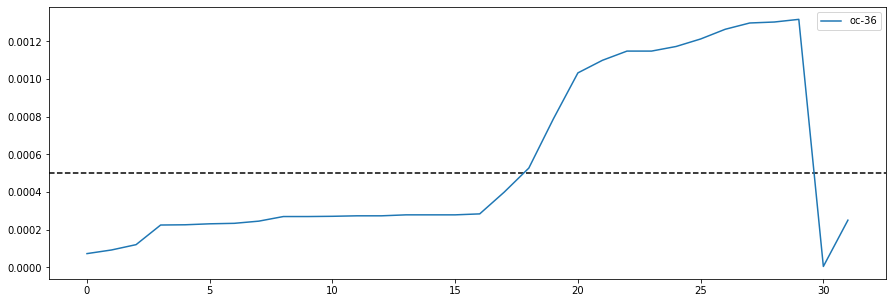

In [287]:
dq_output = simulate_multiple_days(days[19:51],1,ideal_capacity=18)

len(dq_output)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

ax.axhline(0.0005,color='black',linestyle='--')

dq_output_processed = process_simulation_data(dq_output, day_numbers[19:51])
display(dq_output_processed)

df,p = plot_cum_downtime_per_month(dq_output_processed,ax=ax,label=f"oc-{capacities[index]}")


capacity 24 day 0 

active_funcs_during_peak (1m) 98
capacity 24 day 1 

active_funcs_during_peak (1m) 97
capacity 24 day 2 

active_funcs_during_peak (1m) 98
capacity 24 day 3 

active_funcs_during_peak (1m) 98
capacity 24 day 4 

active_funcs_during_peak (1m) 98
capacity 24 day 5 

active_funcs_during_peak (1m) 98
capacity 24 day 6 

active_funcs_during_peak (1m) 85
capacity 24 day 7 

active_funcs_during_peak (1m) 98
capacity 24 day 8 

active_funcs_during_peak (1m) 98
capacity 24 day 9 

active_funcs_during_peak (1m) 98
capacity 24 day 10 

active_funcs_during_peak (1m) 98
capacity 24 day 11 

active_funcs_during_peak (1m) 87
capacity 24 day 12 

active_funcs_during_peak (1m) 94
capacity 24 day 13 

active_funcs_during_peak (1m) 96
capacity 24 day 14 

active_funcs_during_peak (1m) 98
capacity 24 day 15 

active_funcs_during_peak (1m) 98
capacity 24 day 16 

active_funcs_during_peak (1m) 97
capacity 24 day 17 

active_funcs_during_peak (1m) 98


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,147,0.000000,0.364722,0.910087,24,1.0,0.0,NaN,True,False,False
1,148,0.000000,0.350935,0.938579,24,1.0,0.0,NaN,True,False,False
2,149,0.000000,0.325717,0.877757,24,1.0,0.0,NaN,True,False,False
3,150,0.000000,0.333416,0.846207,24,1.0,0.0,NaN,True,False,False
4,151,0.000000,0.333975,0.966305,24,1.0,0.0,NaN,True,False,False
5,152,0.000000,0.375994,0.992504,24,1.0,0.0,NaN,True,False,False
6,153,0.000000,0.293796,0.901104,24,1.0,0.0,NaN,True,False,False
7,154,0.000000,0.345438,0.980321,24,1.0,0.0,NaN,True,False,False
8,155,0.000000,0.328250,0.929875,24,1.0,0.0,NaN,True,False,False
9,156,0.000000,0.337222,0.919454,24,1.0,0.0,NaN,True,False,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,147,0.000000,0.364722,0.910087,24,1.0,0.0,NaN,True,False,False
1,148,0.000000,0.350935,0.938579,24,1.0,0.0,NaN,True,False,False
2,149,0.000000,0.325717,0.877757,24,1.0,0.0,NaN,True,False,False
3,150,0.000000,0.333416,0.846207,24,1.0,0.0,NaN,True,False,False
4,151,0.000000,0.333975,0.966305,24,1.0,0.0,NaN,True,False,False
5,152,0.000000,0.375994,0.992504,24,1.0,0.0,NaN,True,False,False
6,153,0.000000,0.293796,0.901104,24,1.0,0.0,NaN,True,False,False
7,154,0.000000,0.345438,0.980321,24,1.0,0.0,NaN,True,False,False
8,155,0.000000,0.328250,0.929875,24,1.0,0.0,NaN,True,False,False
9,156,0.000000,0.337222,0.919454,24,1.0,0.0,NaN,True,False,False


0 0


rc-quantiles                      18
overload_frequency                18
cluster_daily_utilisation         18
cluster_daily_utilisation_peak    18
cluster_size                      18
cost                              18
savings                           18
growth_savings                     0
slo_violation_0                   18
slo_violation_1                   18
slo_violation_2                   18
dtype: int64

0 0 29 18
1 30


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

1 30 59 0
2 60


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

2 60 89 0
3 90


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

3 90 119 0
4 120


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

4 120 149 0
5 150


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

5 150 179 0
6 180


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

6 180 209 0
7 210


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

7 210 239 0


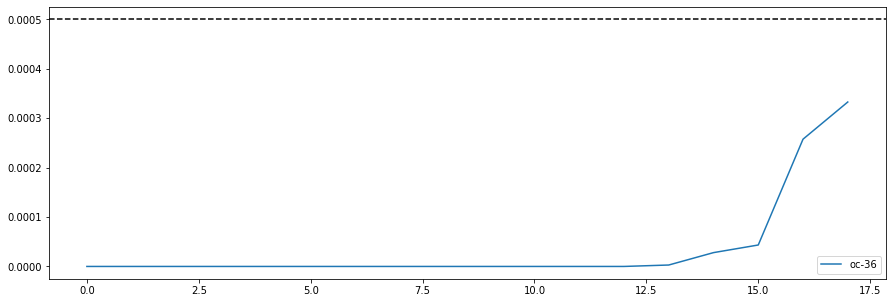

In [286]:
dq_output = simulate_multiple_days(days[72:90],1,ideal_capacity=24)

len(dq_output)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

ax.axhline(0.0005,color='black',linestyle='--')

dq_output_processed = process_simulation_data(dq_output, day_numbers[72:90])
display(dq_output_processed)

df,p = plot_cum_downtime_per_month(dq_output_processed,ax=ax,label=f"oc-{capacities[index]}")


capacity 23 day 0 

active_funcs_during_peak (1m) 98
capacity 23 day 1 

active_funcs_during_peak (1m) 98
capacity 23 day 2 

active_funcs_during_peak (1m) 98
capacity 23 day 3 

active_funcs_during_peak (1m) 98
capacity 23 day 4 

active_funcs_during_peak (1m) 98
capacity 23 day 5 

active_funcs_during_peak (1m) 98
capacity 23 day 6 

active_funcs_during_peak (1m) 96
capacity 23 day 7 

active_funcs_during_peak (1m) 96
capacity 23 day 8 

active_funcs_during_peak (1m) 95
capacity 23 day 9 

active_funcs_during_peak (1m) 96
capacity 23 day 10 

active_funcs_during_peak (1m) 94
capacity 23 day 11 

active_funcs_during_peak (1m) 98
capacity 23 day 12 

active_funcs_during_peak (1m) 98
capacity 23 day 13 

active_funcs_during_peak (1m) 98
capacity 23 day 14 

active_funcs_during_peak (1m) 98
capacity 23 day 15 

active_funcs_during_peak (1m) 98


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,168,0.000000,0.429354,0.997848,23,1.0,0.0,NaN,True,False,False
1,169,0.000000,0.424596,0.960413,23,1.0,0.0,NaN,True,False,False
2,170,0.007971,0.464916,1.038215,23,1.0,0.0,NaN,False,True,False
3,171,0.000332,0.455628,1.027995,23,1.0,0.0,NaN,True,False,False
4,172,0.000000,0.441773,0.981477,23,1.0,0.0,NaN,True,False,False
5,173,0.000000,0.449151,0.972739,23,1.0,0.0,NaN,True,False,False
6,174,0.000000,0.451302,0.942130,23,1.0,0.0,NaN,True,False,False
7,175,0.000000,0.389761,0.963117,23,1.0,0.0,NaN,True,False,False
8,176,0.000000,0.367509,0.844220,23,1.0,0.0,NaN,True,False,False
9,177,0.000000,0.417878,0.954908,23,1.0,0.0,NaN,True,False,False


,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,168,0.000000,0.429354,0.997848,23,1.0,0.0,NaN,True,False,False
1,169,0.000000,0.424596,0.960413,23,1.0,0.0,NaN,True,False,False
2,170,0.007971,0.464916,1.038215,23,1.0,0.0,NaN,False,True,False
3,171,0.000332,0.455628,1.027995,23,1.0,0.0,NaN,True,False,False
4,172,0.000000,0.441773,0.981477,23,1.0,0.0,NaN,True,False,False
5,173,0.000000,0.449151,0.972739,23,1.0,0.0,NaN,True,False,False
6,174,0.000000,0.451302,0.942130,23,1.0,0.0,NaN,True,False,False
7,175,0.000000,0.389761,0.963117,23,1.0,0.0,NaN,True,False,False
8,176,0.000000,0.367509,0.844220,23,1.0,0.0,NaN,True,False,False
9,177,0.000000,0.417878,0.954908,23,1.0,0.0,NaN,True,False,False


0 0


rc-quantiles                      16
overload_frequency                16
cluster_daily_utilisation         16
cluster_daily_utilisation_peak    16
cluster_size                      16
cost                              16
savings                           16
growth_savings                     0
slo_violation_0                   16
slo_violation_1                   16
slo_violation_2                   16
dtype: int64

0 0 29 16
1 30


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

1 30 59 0
2 60


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

2 60 89 0
3 90


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

3 90 119 0
4 120


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

4 120 149 0
5 150


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

5 150 179 0
6 180


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

6 180 209 0
7 210


rc-quantiles                      0
overload_frequency                0
cluster_daily_utilisation         0
cluster_daily_utilisation_peak    0
cluster_size                      0
cost                              0
savings                           0
growth_savings                    0
slo_violation_0                   0
slo_violation_1                   0
slo_violation_2                   0
slo                               0
dtype: int64

7 210 239 0


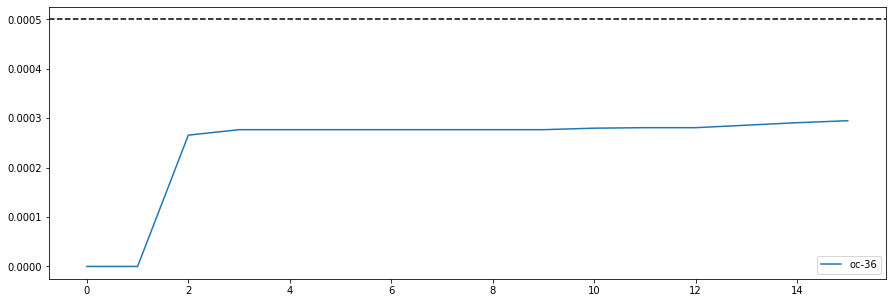

In [288]:
dq_output = simulate_multiple_days(days[91:107],1,ideal_capacity=23)

len(dq_output)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes

ax.axhline(0.0005,color='black',linestyle='--')

dq_output_processed = process_simulation_data(dq_output, day_numbers[91:107])
display(dq_output_processed)

df,p = plot_cum_downtime_per_month(dq_output_processed,ax=ax,label=f"oc-{capacities[index]}")


In [45]:
# open a file, where you stored the pickled data

simulation_data = []

processed_simulation_data = []

for capacity in range(23,37,1):

    file = open(f"/local/scratch/simulation/capacity-{capacity}-lb", 'rb')

    # dump information to that file
    data = pickle.load(file)

    processed = process_simulation_data(data, day_numbers[:141])
    
    simulation_data.append(data)
    processed_simulation_data.append(processed)
    
    # close the file
    file.close()
    
# open a file, where you stored the pickled data

In [27]:

def plot_cum_downtime_per_month(simulation_data,label,ax):

    
#     df = pd.DataFrame()

#     df['days'] = range(234+1)

#     df['overload_frequency'] = simulation_data.set_index('days')['overload_frequency']/30

#     df = df.interpolate()

    df = simulation_data.copy()
    
    df['overload_frequency'] = df['overload_frequency']/30
    

    for month, offset in enumerate(range(0,240,30)):
        
        print(month,offset)
        
        display(df.loc[offset:offset+29].count())

        
        df.loc[offset:offset+29,'slo'] = df.loc[offset:offset+29]['overload_frequency'].cumsum()

        samples = df.loc[offset:offset+29]['overload_frequency'].count()
        
        
#         display(df.loc[offset:offset+30])

#         if samples > 10:

#             df.loc[offset:offset+30,'slo'] = df.loc[offset:offset+30]['overload_frequency']/ 30

#         else:
#             df.loc[offset:offset+30,'slo'] = 0

        print(month, offset,offset+29, samples)

    p = df.plot(y='slo',figsize=(15,5),label=label,ax=ax)
    
    return df,p

0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30
0 0


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
dtype: int64

0 0 29 30
1 30


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

1 30 59 30
2 60


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

2 60 89 30
3 90


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

3 90 119 30
4 120


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

4 120 149 30
5 150


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

5 150 179 30
6 180


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

6 180 209 30
7 210


days                              30
overload_frequency                30
cluster_daily_utilisation_peak    30
slo                                0
dtype: int64

7 210 239 30


(0.0, 0.002)

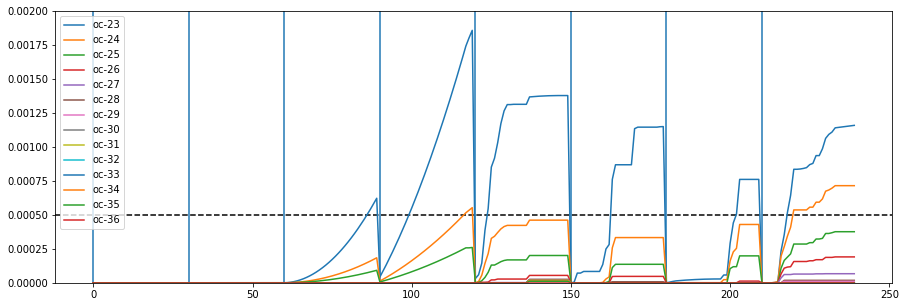

In [220]:
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes



ax.axhline(0.0005,color='black',linestyle='--')
# ax.axhline(0.01)
# ax.axhline(0.05)


capacities = [x for x in range(23,37,1)]

# ax.axhline(0.05)

for month, offset in enumerate(range(0,240,30)):
#     print("month at", offset)
    ax.axvline(offset)

# df_nooc = plot_cum_downtime_per_month(dfsimulation_data_endpointheadroom_q998,label='RC-100 (no oc)',ax=ax)
# df_unsafe5pc = plot_cum_downtime_per_month(dfsimulation_data_endpointheadroom_q997,label='RC-99.97 (unsafe<5%)',ax=ax)
# df_safe = plot_cum_downtime_per_month(dfsimulation_data_endpointheadroom_q99,label='RC-99.93 (safe<0.05%)',ax=ax)

dfs = []
for index, processed in enumerate(processed_simulation_data[:]):
#     procssed['overload_frequency'].plot(figsize=(15,5))

    df,p = plot_cum_downtime_per_month(processed,ax=ax,label=f"oc-{capacities[index]}")
    
#     p.set_xlim((120,240))
    dfs.append(df)
    
    
p.set_ylim(0,0.002)
# plt.yscale('log')    
# plt.show()






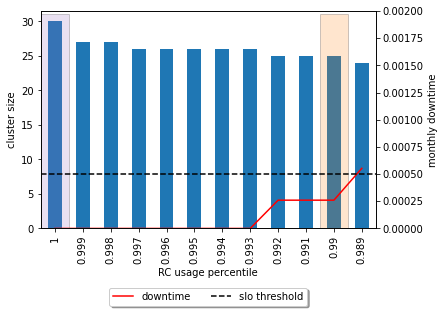

In [233]:


monthly_downtime_per_policy = []

for index, df in enumerate(dfs):
    monthly_downtime = df['slo'].loc[:120].max()
#     print("policy", index,  monthly_downtime> 0.0005, monthly_downtime)
    monthly_downtime_per_policy.append(monthly_downtime)
    
dfmax_monthly_downtime_long_term = pd.DataFrame(index=capacities)    

dfmax_monthly_downtime_long_term['downtime'] = monthly_downtime_per_policy
# dfmax_monthly_downtime_long_term['capacities'] = capacities
    
# pd.Series(monthly_downtime_per_policy).plot(kind='bar')

# plt.axhline(0.0005,color='black',linestyle='--')

dfmax_monthly_downtime_long_term


p = df_loadbalanced_initial['cluster_size'].plot(kind='bar')
twin = p.twinx()
df_loadbalanced_initial['cluster_size'].apply(lambda x: dfmax_monthly_downtime_long_term.loc[x]).plot(ax=twin,color='red')
twin.axhline(0.0005,color='black',linestyle='--',label='slo threshold')

# p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#           fancybox=True, shadow=True, ncol=2)    

twin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=2)


# p.text(3+0.5, 1, "overload <0.05%", fontsize = 10, wrap=True,ha='right')
p.add_patch(Rectangle((0-0.5, 0), 1, 31,  
                edgecolor='black',
                facecolor='tab:purple',
                      alpha=0.2,
                lw=1))     

p.add_patch(Rectangle((10-0.5, 0), 1, 31,  
                edgecolor='black',
                facecolor='tab:orange',
                      alpha=0.2,
                lw=1))  

p.set_ylabel('cluster size')
twin.set_ylim(0,0.002)

twin.set_ylabel('monthly downtime')

p.set_xlabel('RC usage percentile')
# p.set_ylim(0,0.4)


twin.set_xticklabels(quantiles)

plt.savefig("/local/scratch/phd-figures/oracle-oc-limits-initial-capacity.pdf", format="pdf", bbox_inches="tight")    


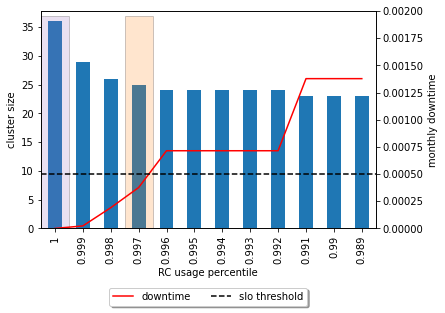

In [234]:


monthly_downtime_per_policy = []

for index, df in enumerate(dfs):
    monthly_downtime = df['slo'].loc[120:].max()
#     print("policy", index,  monthly_downtime> 0.0005, monthly_downtime)
    monthly_downtime_per_policy.append(monthly_downtime)
    
dfmax_monthly_downtime_long_term = pd.DataFrame(index=capacities)    

dfmax_monthly_downtime_long_term['downtime'] = monthly_downtime_per_policy
# dfmax_monthly_downtime_long_term['capacities'] = capacities
    
# pd.Series(monthly_downtime_per_policy).plot(kind='bar')

# plt.axhline(0.0005,color='black',linestyle='--')

dfmax_monthly_downtime_long_term

p = df_loadbalanced_long_term['cluster_size'].plot(kind='bar')
twin = p.twinx()
df_loadbalanced_long_term['cluster_size'].apply(lambda x: dfmax_monthly_downtime_long_term.loc[x]).plot(ax=twin,color='red',label='monthly overload rate')
twin.axhline(0.0005,color='black',linestyle='--',label='slo threshold')

# p.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3),
#           fancybox=True, shadow=True, ncol=2)    

twin.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25),
          fancybox=True, shadow=True, ncol=2)


# p.text(3+0.5, 1, "overload <0.05%", fontsize = 10, wrap=True,ha='right')
p.add_patch(Rectangle((0-0.5, 0), 1, 37,  
                edgecolor='black',
                facecolor='tab:purple',
                      alpha=0.2,
                lw=1))     

p.add_patch(Rectangle((3-0.5, 0), 1, 37,  
                edgecolor='black',
                facecolor='tab:orange',
                      alpha=0.2,
                lw=1))  

p.set_ylabel('cluster size')

p.set_xlabel('RC usage percentile')

twin.set_ylabel('monthly downtime')

twin.set_ylim(0,0.002)

# p.set_ylim(0,0.4)


twin.set_xticklabels(quantiles)

plt.savefig("/local/scratch/phd-figures/oracle-oc-limits-long-term-capacity.pdf", format="pdf", bbox_inches="tight")    


In [182]:
capacities

[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]

<AxesSubplot:>

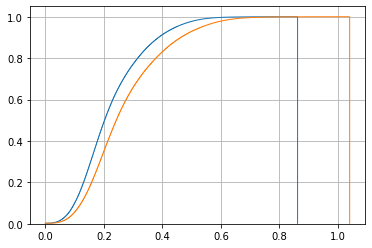

In [217]:
def extract_node_util(sim_day_data):
    
    df = pd.concat([node.sum(axis=1)/server_cpu_capacity for node in sim_day_data])
    return df

pd.concat([extract_node_util(sim_day_data) for sim_day_data in simulation_data[7][:55]]).hist(histtype='step',cumulative=True,density=1,bins=1000) 
pd.concat([extract_node_util(sim_day_data) for sim_day_data in simulation_data[2][:55]]).hist(histtype='step',cumulative=True,density=1,bins=1000) 


<AxesSubplot:>

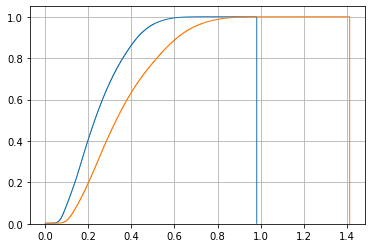

In [218]:
def extract_node_util(sim_day_data):
    
    df = pd.concat([node.sum(axis=1)/server_cpu_capacity for node in sim_day_data])
    return df

pd.concat([extract_node_util(sim_day_data) for sim_day_data in simulation_data[-1][55:]]).hist(histtype='step',cumulative=True,density=1,bins=1000) 
pd.concat([extract_node_util(sim_day_data) for sim_day_data in simulation_data[2][55:]]).hist(histtype='step',cumulative=True,density=1,bins=1000) 


# Capacity requirements comparison

In [235]:
df_loadbalanced_initial

,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.269753,0.858755,30,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.000000,0.299726,0.971790,27,0.900000,0.100000,0.500000,True,False,False
2,0.998,0.000000,0.299726,0.962591,27,0.900000,0.100000,0.500000,True,False,False
3,0.997,0.000321,0.311254,1.055215,26,0.866667,0.133333,0.666667,True,False,False
4,0.996,0.000294,0.311254,1.063928,26,0.866667,0.133333,0.666667,True,False,False
5,0.995,0.000321,0.311254,1.063913,26,0.866667,0.133333,0.666667,True,False,False
6,0.994,0.000000,0.311254,0.981018,26,0.866667,0.133333,0.666667,True,False,False
7,0.993,0.000000,0.311254,0.981570,26,0.866667,0.133333,0.666667,True,False,False
8,0.992,0.000000,0.323704,0.998996,25,0.833333,0.166667,0.833333,True,False,False
9,0.991,0.000028,0.323704,1.004259,25,0.833333,0.166667,0.833333,True,False,False


In [236]:
df_loadbalanced_long_term

,rc-quantiles,overload_frequency,cluster_daily_utilisation,cluster_daily_utilisation_peak,cluster_size,cost,savings,growth_savings,slo_violation_0,slo_violation_1,slo_violation_2
0,1.000,0.000000,0.233173,0.982143,36,1.000000,0.000000,0.000000,True,False,False
1,0.999,0.000694,0.289456,1.246744,29,0.805556,0.194444,0.538462,False,True,False
2,0.998,0.000908,0.322855,1.395699,26,0.722222,0.277778,0.769231,False,True,False
3,0.997,0.001139,0.335769,1.447130,25,0.694444,0.305556,0.846154,False,True,False
4,0.996,0.001302,0.349760,1.509130,24,0.666667,0.333333,0.923077,False,True,False
5,0.995,0.001244,0.349760,1.498470,24,0.666667,0.333333,0.923077,False,True,False
6,0.994,0.001215,0.349760,1.484883,24,0.666667,0.333333,0.923077,False,True,False
7,0.993,0.001186,0.349760,1.492854,24,0.666667,0.333333,0.923077,False,True,False
8,0.992,0.001157,0.349760,1.493766,24,0.666667,0.333333,0.923077,False,True,False
9,0.991,0.001691,0.364967,1.561840,23,0.638889,0.361111,1.000000,False,True,False


In [247]:
df_loadbalanced_initial['cluster_size'].iloc[10], df_loadbalanced_long_term['cluster_size'].iloc[3], 

(25, 25)

In [248]:
df_loadbalanced_initial['savings'].iloc[10], df_loadbalanced_long_term['savings'].iloc[3], 

(0.16666666666666663, 0.3055555555555556)

In [252]:
 1-df_loadbalanced_long_term['cluster_size'].iloc[3]/30, 

(0.16666666666666663,)

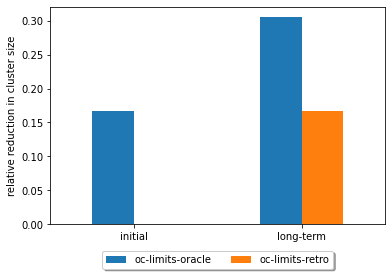

In [254]:
dfsavings = pd.DataFrame()

# dfsavings['peak-limits'] = [27,36]

dfsavings['oc-limits-oracle'] = [0.16666666666666663, 0.3055555555555556]

dfsavings['oc-limits-retro'] = [0,0.16666666666666663]



(dfsavings).plot(kind='bar',color=['tab:blue','tab:orange','tab:green',])

# plt.text(0.1, 0.75, "16% saving", fontsize = 10, wrap=True,ha='left',color='tab:green')   

# plt.text(1.1, 0.75, "30% saving", fontsize = 10, wrap=True,ha='left',color='tab:green')  

# plt.text(0.95, 0.9, "16% saving", fontsize = 10, wrap=True,ha='left',color='tab:orange')   


# plt.show()

# dfsavings[['no-oc','retro-oc']].plot(kind='bar',color=['tab:blue','tab:orange'])


# plt.text(1.1, 30, "15% saving", fontsfaize = 10, wrap=True,ha='left')     

plt.legend(loc='lower left')


plt.xticks([0,1],["initial","long-term"],rotation='horizontal')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=3)

plt.ylabel('relative reduction in cluster size')

plt.savefig("/local/scratch/phd-figures/workload-growth-bar.pdf", format="pdf", bbox_inches="tight")

plt.show()

